# Comparison of online CCA algorithms

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# import cca algorithms

from biocca import bio_cca
from msgcca import msg_cca
from genoja import gen_oja
from CCAPyramidal import CCAPyramidal # package for the asymmetric CCA network
from biorrr import bio_rrr

from util import correlation_matrix, obj_error, msg_error, subspace_error, constraint_error, add_fill_lines

### Load dataset

In [2]:
# select the desired dataset and number of epochs

dataset = 'synthetic'; epochs = 1
# dataset = 'mediamill'; epochs = 3

# load dataset

X = np.load(f'datasets/{dataset}/view1.npy')
Y = np.load(f'datasets/{dataset}/view2.npy')

# dataset dimensions

x_dim = X.shape[0]
y_dim = Y.shape[0]
samples = X.shape[1]

### Offline solution

In [3]:
# Covariance matrices

Cxx = X@X.T/samples
Cyy = Y@Y.T/samples
Cxy = X@Y.T/samples

# Inverse matrices

sig_y, Uy = np.linalg.eig(Cyy)

Cyy_inv = Uy@np.diag(1./sig_y)@Uy.T

# Correlation matrix

Rxy = correlation_matrix(Cxx, Cyy, Cxy)

# SVD

u, canonical_correlations, vh = np.linalg.svd(Rxy)

### Online algorithms

In [4]:
# Parameters

trials = 5; z_dim = 1; iters = epochs*samples; training_samples = 1000

In [5]:
# Maximum of the objective

max_obj = sum(canonical_correlations[:z_dim])/2

In [6]:
# Optimal subspace projections

Ux = u[:,:z_dim]
Uy = vh.T[:,:z_dim]

Px_opt = Ux@np.linalg.inv(Ux.T@Ux)@Ux.T
Py_opt = Uy@np.linalg.inv(Uy.T@Uy)@Uy.T

In [7]:
# Specify which algorithms to run

algorithms = []

algorithms.append('Bio-CCA')
algorithms.append('MSG-CCA')
if z_dim==1: algorithms.append('Gen-Oja')
algorithms.append('Asymmetric-CCA')
algorithms.append('Bio-RRR')

In [8]:
alg_time = {}
alg_Vx = {}
alg_Vy = {}
alg_M = {}

for alg in algorithms:
    alg_time[alg] = np.zeros((trials,iters))
    
    if alg!='MSG-CCA':
        alg_Vx[alg] = np.zeros((trials,iters,x_dim,z_dim))
        alg_Vy[alg] = np.zeros((trials,iters,y_dim,z_dim))
    elif alg=='MSG-CCA':
        alg_M[alg] = np.zeros((trials,iters,x_dim,y_dim))

In [9]:
start_time = time.time()

for i_trial in range(trials):
    
    print(f'Trial {i_trial+1} out of {trials}:')
                
    # Initialize algorithms
    
    if 'Bio-CCA' in algorithms:
        biocca = bio_cca(z_dim,x_dim,y_dim,dataset)   
    
    if 'MSG-CCA' in algorithms:
        msgcca = msg_cca(z_dim,x_dim,y_dim)
        
    if 'Asymmetric-CCA' in algorithms:
        if dataset=='synthetic': asycca = CCAPyramidal(X,Y,k=z_dim,eta={"W":0.0002,"V":0.0002,"M":0.0002,"Lambda":0.0002,"Gamma":0.0002},steps=iters,alpha=5e-6,mode="hierarchy")
        elif dataset=='mediamill': asycca = CCAPyramidal(X,Y,k=z_dim,eta={"W":0.002,"V":0.002,"M":0.002,"Lambda":0.002,"Gamma":0.002},steps=iters,alpha=5e-6,mode="hierarchy")
        
    if 'Bio-RRR' in algorithms:
        biorrr = bio_rrr(z_dim,x_dim,y_dim,dataset)

    if 'Gen-Oja' in algorithms:
        genoja = gen_oja(x_dim,y_dim,dataset)
            
    # Run online algorithms
    
    print('Running online algorithms...')
    
    for i_epoch in range(epochs):
        
        print(f'Epoch {i_epoch+1} out of {epochs}:')
        
        # Random permutation of the inputs

        idx = np.random.permutation(samples)
    
        # MSG-CCA covariance estimation on training samples

        if i_epoch==0 and 'MSG-CCA' in algorithms:
            checkpoint = time.time()
            msgcca.cov_estimation(X[:,idx[:]],Y[:,idx[:]])
            alg_time['MSG-CCA'][i_trial,:training_samples-1] = time.time() - checkpoint
            
        # Online updates

        for i_sample in range(samples):
            
            i_iter = i_epoch*samples + i_sample

            x = X[:,idx[i_sample]]
            y = Y[:,idx[i_sample]]

            # online updates

            if 'Bio-CCA' in algorithms:
                checkpoint = time.time()
                alg_Vx['Bio-CCA'][i_trial,i_iter], alg_Vy['Bio-CCA'][i_trial,i_iter] = biocca.fit_next(x,y)
                alg_time['Bio-CCA'][i_trial,i_iter] = alg_time['Bio-CCA'][i_trial,max(i_iter-1,0)] + time.time() - checkpoint
            if 'MSG-CCA' in algorithms: 
                checkpoint = time.time()
                alg_M['MSG-CCA'][i_trial,i_iter] = msgcca.fit_next(x,y)
                alg_time['MSG-CCA'][i_trial,i_iter] = alg_time['MSG-CCA'][i_trial,max(i_iter-1,0)] + time.time() - checkpoint
            if 'Asymmetric-CCA' in algorithms: 
                checkpoint = time.time()
                asycca.online_step(idx[i_sample], asycca.decay(i_iter))
                alg_Vx['Asymmetric-CCA'][i_trial,i_iter], alg_Vy['Asymmetric-CCA'][i_trial,i_iter] = asycca.W, asycca.V
                alg_time['Asymmetric-CCA'][i_trial,i_iter] = alg_time['Asymmetric-CCA'][i_trial,max(i_iter-1,0)] + time.time() - checkpoint
            if 'Bio-RRR' in algorithms: 
                checkpoint = time.time()
                alg_Vx['Bio-RRR'][i_trial,i_iter], alg_Vy['Bio-RRR'][i_trial,i_iter] = biorrr.fit_next(x,y)
                alg_time['Bio-RRR'][i_trial,i_iter] = alg_time['Bio-RRR'][i_trial,max(i_iter-1,0)] + time.time() - checkpoint
            if 'Gen-Oja' in algorithms: 
                checkpoint = time.time()
                alg_Vx['Gen-Oja'][i_trial,i_iter], alg_Vy['Gen-Oja'][i_trial,i_iter] = genoja.fit_next(x,y)
                alg_time['Gen-Oja'][i_trial,i_iter] = alg_time['Gen-Oja'][i_trial,max(i_iter-1,0)] + time.time() - checkpoint
                
        print(f'Elapsed time: {time.time()-start_time} seconds')
        
print('Trials complete')

Trial 1 out of 5:
Running online algorithms...
Epoch 1 out of 1:
Elapsed time: 439.04592514038086 seconds
Trial 2 out of 5:
Running online algorithms...
Epoch 1 out of 1:
Elapsed time: 882.5195782184601 seconds
Trial 3 out of 5:
Running online algorithms...
Epoch 1 out of 1:
Elapsed time: 1332.4498009681702 seconds
Trial 4 out of 5:
Running online algorithms...
Epoch 1 out of 1:
Elapsed time: 1771.083848953247 seconds
Trial 5 out of 5:
Running online algorithms...
Epoch 1 out of 1:
Elapsed time: 2210.189551115036 seconds
Trials complete


### Compute errors

In [10]:
domain = list(sorted(set(map(int, np.round(np.logspace(0, np.log10(iters), num=50, endpoint=False))))))

In [11]:
alg_obj_error = {}
alg_subspacex_error = {}
alg_constraint_error = {}

for alg in algorithms:
    if alg!='Bio-RRR':
        alg_obj_error[alg] = np.zeros((trials,iters))
    if alg!='MSG-CCA':
        alg_subspacex_error[alg] = np.zeros((trials,iters))
    if alg=='Bio-CCA':
        alg_constraint_error[alg] = np.zeros((trials,iters))

In [12]:
for i_trial in range(trials):
    for i_iter in domain:
        if 'Bio-CCA' in algorithms:
            Vx, Vy = alg_Vx['Bio-CCA'][i_trial,i_iter], alg_Vy['Bio-CCA'][i_trial,i_iter]
            alg_obj_error['Bio-CCA'][i_trial,i_iter] = obj_error(Vx, Vy, Cxx, Cyy, Cxy, max_obj)
            alg_subspacex_error['Bio-CCA'][i_trial,i_iter] = subspace_error(Vx, Px_opt)
            alg_constraint_error['Bio-CCA'][i_trial,i_iter] = constraint_error(Vx, Vy, Cxx, Cyy)
        if 'MSG-CCA' in algorithms: 
            M = alg_M['MSG-CCA'][i_trial,i_iter]
            alg_obj_error['MSG-CCA'][i_trial,i_iter] = msg_error(M, Rxy, max_obj)
        if 'Asymmetric-CCA' in algorithms: 
            Vx, Vy = alg_Vx['Asymmetric-CCA'][i_trial,i_iter], alg_Vy['Asymmetric-CCA'][i_trial,i_iter]
            alg_obj_error['Asymmetric-CCA'][i_trial,i_iter] = obj_error(Vx, Vy, Cxx, Cyy, Cxy, max_obj)
            alg_subspacex_error['Asymmetric-CCA'][i_trial,i_iter] = subspace_error(Vx, Px_opt)
        if 'Bio-RRR' in algorithms:
            Vx, Vy = alg_Vx['Bio-RRR'][i_trial,i_iter], alg_Vy['Bio-RRR'][i_trial,i_iter]
            alg_subspacex_error['Bio-RRR'][i_trial,i_iter] = subspace_error(Vx, Px_opt)
        if 'Gen-Oja' in algorithms: 
            Vx, Vy = alg_Vx['Gen-Oja'][i_trial,i_iter], alg_Vy['Gen-Oja'][i_trial,i_iter]
            alg_obj_error['Gen-Oja'][i_trial,i_iter] = obj_error(Vx, Vy, Cxx, Cyy, Cxy, max_obj)
            alg_subspacex_error['Gen-Oja'][i_trial,i_iter] = subspace_error(Vx, Px_opt)

### Comparison plots

In [13]:
font = {'weight' : 'normal', 'size' : 15}

plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13) 

plt.rc('font', **font)

In [14]:
colors = {}

colors['Bio-CCA'] = 'tab:blue'
colors['MSG-CCA'] = 'tab:orange'
colors['Gen-Oja'] = 'tab:green'
colors['Asymmetric-CCA'] = 'tab:red'
colors['Bio-RRR'] = 'tab:purple'

In [15]:
styles = {}

styles['Bio-CCA'] = 'solid'
styles['MSG-CCA'] = 'dashed'
styles['Gen-Oja'] = 'dotted'
styles['Asymmetric-CCA'] = 'dashdot'
styles['Bio-RRR'] = 'dashed'

In [16]:
labels = {}

labels['Bio-CCA'] = 'Bio-CCA'
labels['MSG-CCA'] = 'MSG-CCA'
labels['Gen-Oja'] = 'Gen-Oja'
labels['Asymmetric-CCA'] = 'Asym-NN'
labels['Bio-RRR'] = 'Bio-RRR'

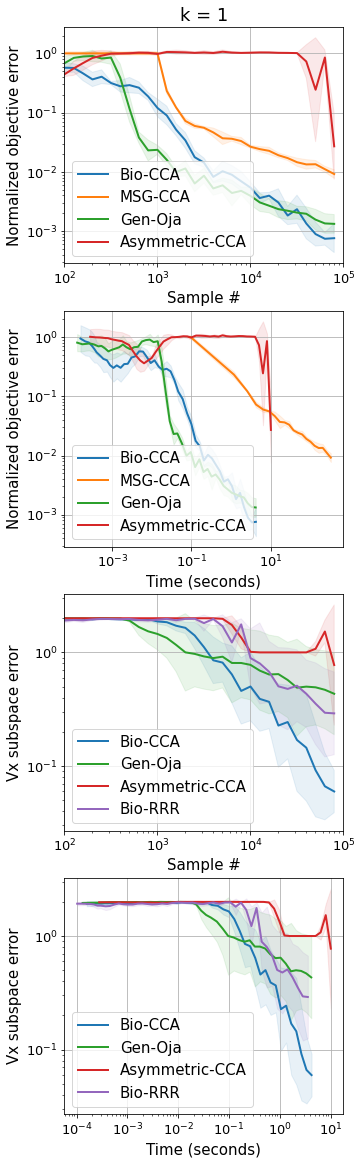

In [17]:
linewidth = 2

fig = plt.figure(figsize=(5,20))

ax = plt.subplot(4, 1, 1)

for alg in algorithms:
    if alg!='Bio-RRR':
        add_fill_lines(ax, domain, alg_obj_error[alg][:,domain], plot_kwargs={'ls': '-', 'lw': linewidth, 'label': alg, 'color': colors[alg]}, ci_kwargs={'color': colors[alg]})

ax.loglog()

plt.title(f"k = {z_dim}")
plt.grid()
plt.legend(loc = 'lower left')
plt.xlim((1e2,iters))
plt.xlabel('Sample #')
plt.ylabel('Normalized objective error')

ax = plt.subplot(4, 1, 2)

for alg in algorithms:
    if alg!='Bio-RRR':
        add_fill_lines(ax, np.mean(alg_time[alg][:,domain],axis=0), alg_obj_error[alg][:,domain], plot_kwargs={'ls': '-', 'lw': linewidth, 'label': alg, 'color': colors[alg]}, ci_kwargs={'color': colors[alg]})

ax.loglog()

plt.grid()
plt.legend(loc = 'lower left')
plt.xlabel('Time (seconds)')
plt.ylabel('Normalized objective error')

ax = plt.subplot(4, 1, 3)

for alg in algorithms:
    if alg!='MSG-CCA':
        add_fill_lines(ax, domain, alg_subspacex_error[alg][:,domain], plot_kwargs={'ls': '-', 'lw': linewidth, 'label': alg, 'color': colors[alg]}, ci_kwargs={'color': colors[alg]})

ax.loglog()

plt.grid()
plt.legend(loc = 'lower left')
plt.xlim((1e2,iters))
plt.xlabel('Sample #')
plt.ylabel('Vx subspace error')

ax = plt.subplot(4, 1, 4)

for alg in algorithms:
    if alg!='MSG-CCA':
        add_fill_lines(ax, np.mean(alg_time[alg][:,domain],axis=0), alg_subspacex_error[alg][:,domain], plot_kwargs={'ls': '-', 'lw': linewidth, 'label': alg, 'color': colors[alg]}, ci_kwargs={'color': colors[alg]})

ax.loglog()

plt.grid()
plt.legend(loc = 'lower left')
plt.xlabel('Time (seconds)')
plt.ylabel('Vx subspace error')

plt.show()

##### Bio-CCA constraint error

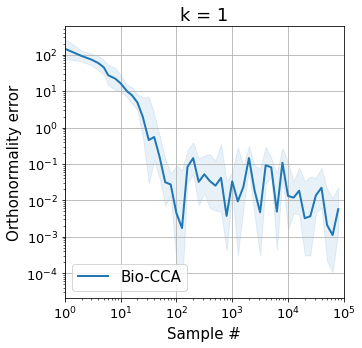

In [18]:
linewidth = 2

domain = list(sorted(set(map(int, np.round(np.logspace(0, np.log10(iters), num=50, endpoint=False))))))

fig = plt.figure(figsize=(5,5))

ax = plt.subplot(1, 1, 1)

add_fill_lines(ax, domain, alg_constraint_error['Bio-CCA'][:,domain], plot_kwargs={'ls': '-', 'lw': linewidth, 'label': 'Bio-CCA', 'color': colors['Bio-CCA']}, ci_kwargs={'color': colors['Bio-CCA']})

ax.loglog()

plt.title(f"k = {z_dim}")
plt.grid()
plt.legend(loc = 'lower left')
plt.xlim((1e0,iters))
plt.xlabel('Sample #')
plt.ylabel('Orthonormality error')

plt.show()